In [1]:
import gammapy
print(gammapy.__version__ , " == 1")

0.1.dev19174+g56b5bdf  == 1


In [2]:
import numpy as np
import os
import astropy
from astropy import units as u
from collections import OrderedDict
from astropy import units
from gammapy.data import DataStore
from astropy.io import fits
from astropy.coordinates import SkyCoord
from gammapy.data import FixedPointingInfo, Observation, DataStore
from astropy.coordinates import SkyOffsetFrame
from gammapy.maps import WcsNDMap, WcsGeom, MapAxis, Map
from gammapy.makers import MapDatasetMaker
from gammapy.datasets import MapDataset
from gammapy.irf import load_cta_irfs, EDispKernel, PSFKernel
from gammapy.modeling import Fit
from  gammapy.makers import SafeMaskMaker
from gammapy.modeling.models import (
    Models,
    FoVBackgroundModel,
)
from regions import CircleSkyRegion, RectangleSkyRegion


In [3]:
# define some functions for the geometry
def get_ebins():
    min_energy = 0
    ebins = np.logspace(-1,2,25)
    e_edges = ebins.copy()[np.where(ebins>=min_energy)[0][0]:]
    return e_edges*u.TeV

def get_geom():    

    geom_set = dict(
            width = (lon_width * u.deg, lat_width * u.deg),
            pix_size = pix_size * u.deg,
            e_edges  = get_ebins(),
            sky_dir = pks_pos,
            frame = 'icrs'
        )

    eaxis = MapAxis.from_edges(geom_set['e_edges'], name='energy', interp='log')

    geom = WcsGeom.create(
        skydir=geom_set['sky_dir'],
        binsz=geom_set['pix_size'],
        width=geom_set['width'],
        frame=geom_set['frame'],
        proj='CAR',
        axes=[eaxis],
    )

    geom_2d = geom.slice_by_idx(dict(energy=1))

    return geom, geom_2d



## Reading and peeking into the Datastore
The data is the HESS public PKS2155 steady runs. 
See info https://www.mpi-hd.mpg.de/HESS/pages/dl3-dr1/hess_dl3_dr1.pdf

In [4]:
source = 'PKS'
if source == "PKS":
    pks = True
    msh = False
if source == "MSH":
    pks = False
    msh = True

if pks:
    path = 'hess_data/std_fullEnclosure/pks2155_flare/out/'
if msh:
    path = 'hess_data/std_fullEnclosure/msh1552/out'
    

#copied from /home/wecapstor1/caph/shared/hess/fits/fits_data/fits_paper_data.tar.gz
path_saving = os.getcwd() 
data_store = DataStore.from_dir(path, f'hdu-index-bg-v05-fov-radec.fits.gz', f'obs-index-bg-v05-fov-radec.fits.gz')
hdul = fits.open(f"{path}/obs-index-bg-v05-fov-radec.fits.gz")
try:
    # File with all the obs ids to analyse
    obsid = f'obsid_{source}.txt'
    obsid = np.loadtxt(obsid)
except:
    string = ''
    for o in data_store.obs_ids:
        string += str(o) + '\n'
    print(string)
    with open(f'obsid_{source}.txt', 'w') as f:
        f.write(string)
    obsid = f'obsid_{source}.txt'
    obsid = np.loadtxt(obsid)




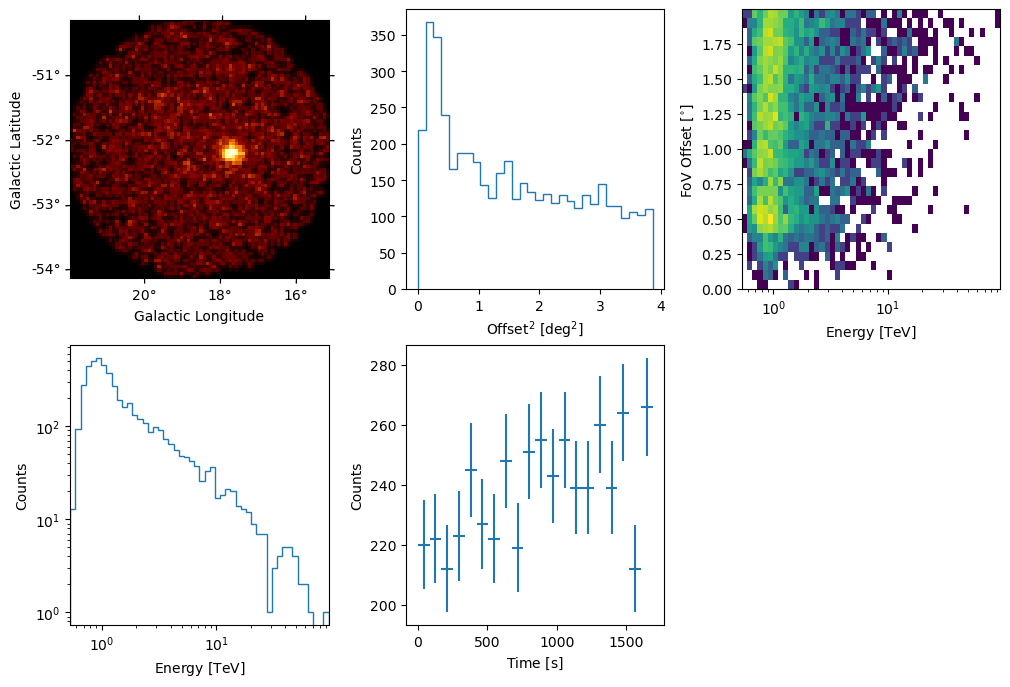

/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


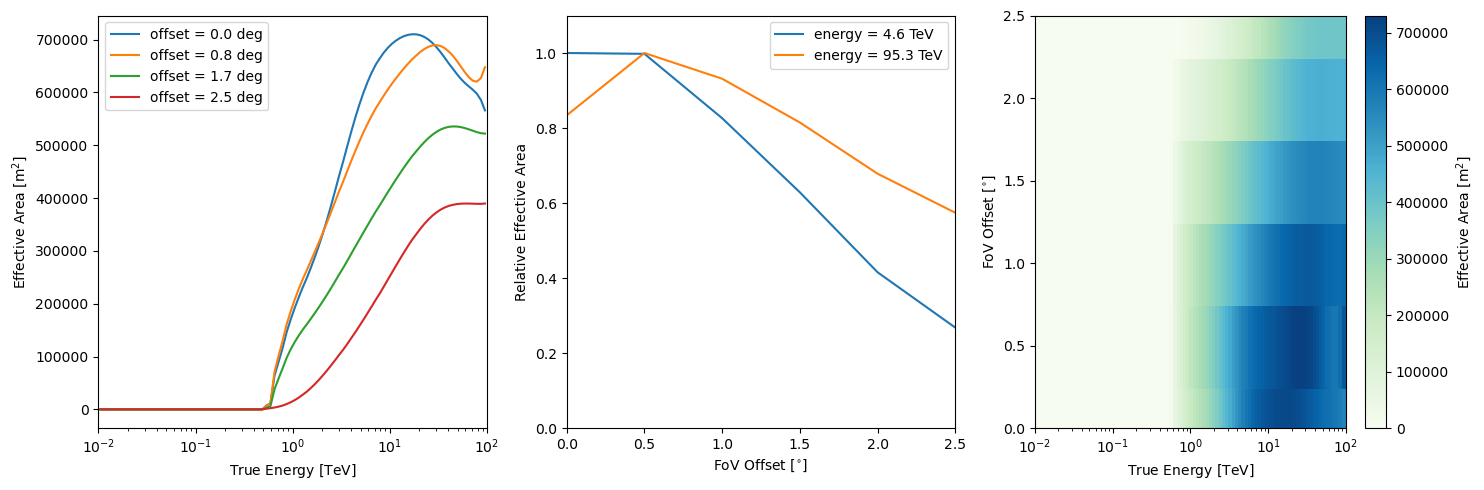

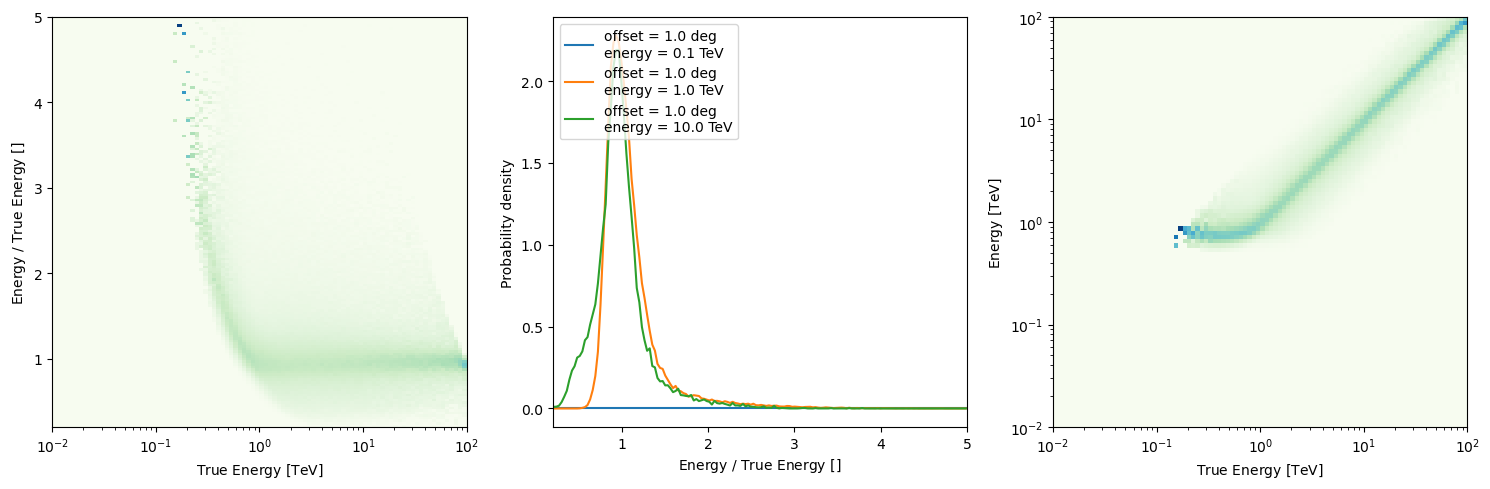

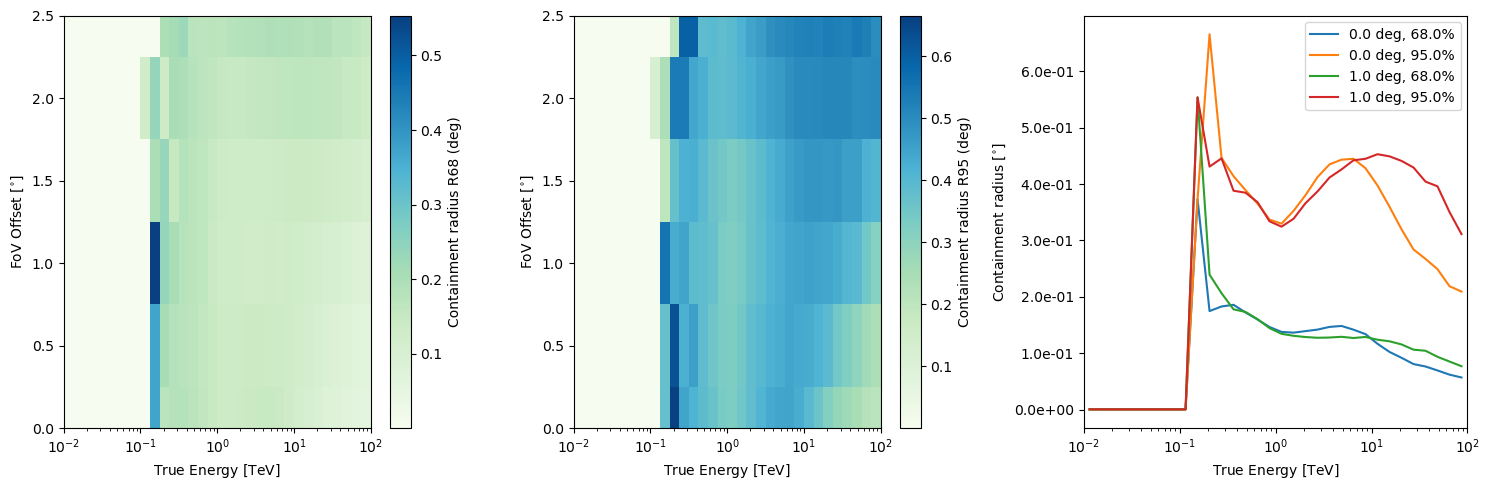

Missing 'HDUCLAS2' keyword assuming 'BKG'


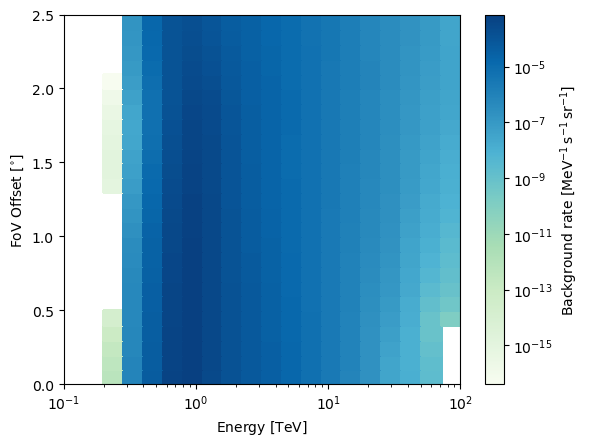

In [5]:
## looking at observation 0 as an example
import matplotlib.pyplot as plt

obs = data_store.obs(obsid[0])
obs.events.select_offset([0, 2] * u.deg).peek()
plt.show()

obs.aeff.peek()
plt.show()

obs.edisp.peek()
plt.show()

obs.psf.peek()
plt.show()

obs.bkg.to_2d().plot()
plt.show()

In [ ]:
# some info 
ontime=[]
livetime=[]
timeobs=[]
date=[]
angle=[]
observations = data_store.get_observations(obsid)
for obs in observations:
    livetime.append(obs.observation_live_time_duration.value)
    #date.append(obs.obs_info['DATE-OBS'][0:4])
    date.append(obs.tstart)
    #angle.append(obs.obs_info['ZEN_PNT']) info not here anymore
    # compute zenith (0 at top) by 90 - altitude
    angle.append(90-obs.obs_info['ALT_PNT'])

timeobs=np.array(timeobs)
  
print(f'runs: {len(observations)}')
print(f'livetime: {np.sum(livetime)/3600:.3} hr')
print('date:','{}-{}'.format(min(date),max(date)))
print(f'avg zenith: {np.mean(angle):.3} pm {np.std(angle):.3} deg')
print(f'duration[max,min]: {np.max(livetime)/60,np.min(livetime)/60}')
#print('duration:',timeobs/60)
plt.hist(angle)
plt.xlabel('Zenith [Deg]')

In [ ]:
# setting the position of the source
if pks:
    pks_pos = SkyCoord("21h58m43.2s", "-30d13m18s")
    pks_pos = SkyCoord(frame = "galactic",l =  "17.74 deg", b= "-52.25 deg")
    print(pks_pos)
if msh:
    #https://www.mpi-hd.mpg.de/HESS/pages/home/sources/
    pks_pos = SkyCoord(frame = "galactic",l =  "320.33 deg", b= "-1.19 deg")
    print(pks_pos)
    

## 2. Computing the Energy Threshold
We want to analyse the data only above a certain energy threshold for which we are sure to have reconstructed the data well.

There are two criteria: 
1. The energy bias is smaller than 10 % (stored in ``threshold.txt``)
2. The background rate is smaller than the peak value. (stored in ``bkgthreshold.txt``)

In the end we will use the maximum value of those. 



### 2.1. Energy Bias < 10 % Threshold

In [ ]:
# define txt files in which the two different thresholds are written into

store_threshold = f'thresholds/threshold_{source}.txt'
store_bgthreshold = f'thresholds/bkg_threshold_{source}.txt'

config = 'std_ImPACT_fullEnclosure'
max_offset = 2.0 
min_energy = 0
ebins = get_ebins()
energy_binning = ebins.copy()[np.where(ebins>=min_energy)[0][0]:] #ebins.copy()[np.where(ebins>=min_energy)[0][0]-1:]





In [ ]:

emax=10*units.TeV
# open file to print into
with open(store_threshold, 'w') as f:

    for obs in observations:
        thr_offset = max_offset * units.deg

        # extract energy dispersion for maximum offset
        edisp = obs.edisp.to_edisp_kernel(thr_offset, energy=energy_binning, energy_true=energy_binning)
        e_true = edisp.axes['energy_true'].center
        values = edisp.get_bias(e_true)
        plt.figure()
        # determine threshold from energy dispersion
        threshold = edisp.get_bias_energy(0.1,energy_min=e_true[np.nanargmax(values)],energy_max=emax)[0]
        if e_true[np.nanargmax(values)]>emax:
            threshold = edisp.get_bias_energy(0.1,energy_min=e_true[np.nanargmax(values[0:20])],energy_max=emax)[0]

        # use lower edge of first bin above threshold
        threshold = energy_binning[np.where(~(energy_binning.value[:-1]<threshold.value))[0][0]]

        threshold = np.floor(1e4*threshold)/1e4
        #print to file
        print(obs.obs_id, '  {:.4f}'.format(threshold.value),  file=f)
        print('')

        #if threshold.value>1:
        import matplotlib.pyplot as plt
        plt.plot(e_true,values, 'x-')
        plt.axvline(x=threshold.value,color='r', )
        plt.xscale('log')
        #plt.yscale('log')
        plt.xlabel("True Energy [TeV]")
        plt.ylabel("Energy Bias")
        plt.title(obs.obs_id)
        plt.show()



### 2.2. Background Peak Threshold



In [ ]:

maker = MapDatasetMaker(background_oversampling=2, selection=['background'])
bgmodel_version = 'v08c'


min_energies = {}

# open file to print into
with open(store_bgthreshold, 'w') as f:

    ra_pnt = data_store.obs_table['RA_PNT']
    dec_pnt = data_store.obs_table['DEC_PNT']

    min_energies[source] = OrderedDict()

    for j in range(len(observations)):
        obs = observations[j]
        print('t ', obs.obs_id)
        e_thres = obs.aeff.meta['LO_THRES']
        eaxis = MapAxis.from_edges(get_ebins(), unit='TeV', name='energy', interp='log')

        geom = WcsGeom.create(
            skydir=obs.pointing_radec,
            binsz=0.02,
            width=(4.3, 4.3),
            frame='icrs',
            proj='CAR',
            axes=[eaxis],
        )
        bg_map = maker.make_background(geom, obs)


        bg_rate = bg_map.data.sum(axis=(1,2)) / np.diff(eaxis.edges)
        plt.figure()
        plt.plot(eaxis.center.value, bg_rate)
        plt.ylabel('BG Rate [1/ TeV]')
        plt.xscale('log')
        plt.title(obs.obs_id)
        
        print('    threshold from aeff fits file is {:.4f} TeV'.format(e_thres))
         # print to file
        print(obs.obs_id, '  {:.4f}'.format(e_thres), file=f)
        emin = eaxis.edges[1:][np.argmax(bg_rate)]
        emin = np.floor(1e4*emin)/1e4
        plt.axvline(x=emin.value,color='green', )
        
        print('    max rate of {:.2f} in bin {:d}, upper edge {:.4f} TeV'.format(np.max(bg_rate), np.argmax(bg_rate), emin))
        
        min_energies[source][obs.obs_id] = emin


## Compare Thresholds

In [ ]:
thres_list = store_threshold#"threshold.txt"
thresholds = np.loadtxt(thres_list)
bgthres_list = store_bgthreshold#"bkg_threshold.txt"
bgthresholds = np.loadtxt(bgthres_list)
#pick the one with max value
maxthreshold = np.array(list(map(max, zip(thresholds[:,1], bgthresholds[:,1]))))


In [ ]:
plt.scatter(angle,thresholds[:,1], label  = "10% Bias Threshold", color = 'r')
plt.scatter(angle,bgthresholds[:,1],label  = "BKG Peak Threshold", color = 'green')
plt.legend()
plt.xlabel("Zenith Angle")
plt.ylabel("Threshold [TeV]")
if pks:
    plt.title(f"PKS 2155−304 - flare \n nruns: {len(observations)}")
fig = plt.gcf()
fig.savefig(f"plots/1-thresholds_zenith_{source}.png")

## 3. Run-wise BKG Fitting and Dataset Creation

In [ ]:
# define exclusion region around the source
excl_regions = []
lon_width,lat_width,pix_size = 10,10,0.02
radius = 0.25*u.deg
skyregion = CircleSkyRegion(center=pks_pos, radius=radius)
excl_regions = [skyregion]
excl_mask_2d = Map.from_geom(get_geom()[1], data=get_geom()[1].region_mask(excl_regions, inside=False).data)
excl_mask_2d.plot(add_cbar = 1, vmin =0, vmax = 1);

In [ ]:
%%time
max_offset = 2*u.deg
geom = get_geom()[0]

maker = MapDatasetMaker(background_oversampling=2)
maker_safe_mask = SafeMaskMaker(methods=['offset-max'], offset_max=max_offset)
dataset_stacked = MapDataset.create(geom=geom, name='stacked')

bg_norms_  , bg_tilts_ = [], []

for i,obs in enumerate(observations):
    print(i, obs)
    plt.figure(figsize = (13,5))
    
    reference = MapDataset.create(geom=geom, name='stacked').cutout(position=obs.pointing_radec, width=8.0*max_offset)    
    dataset = maker.run(reference, obs)
    dataset = maker_safe_mask.run(dataset, obs)
    
    bkg_model = FoVBackgroundModel(dataset_name="{}".format(dataset.name))
    models = Models([bkg_model])
    dataset.models = models
    dataset.background_model.spectral_model.tilt.frozen = False

    dataset.mask_safe.data[:] &= excl_mask_2d.data
    ebins = get_ebins()
    emask = ebins[:-1].value >= maxthreshold[i]
    
    dataset.mask_safe.data[~emask,:,:] = False
    fit = Fit(optimize_opts={"print_level": 1})
    result = fit.run(datasets=[dataset])
    print(dataset)
    ax = dataset.plot_residuals(kwargs_spatial = {'vmax': 0.2, 'vmin': -0.2})
    mask_obs_max_offset = geom.to_image().region_mask(
        [CircleSkyRegion(obs.pointing_radec, radius=max_offset)], inside=True
    )
    dataset.mask_safe.data[emask] = dataset.mask_safe.data[emask] | mask_obs_max_offset

    assert np.isfinite(dataset.background.data[dataset.mask_safe.data]).all()
    dataset.background.data[~dataset.mask_safe.data] = 0.0

    dataset_stacked.stack(dataset)
    # save all datasets
    if pks:
        dataset.write('{}/runwise_datasets/dataset-obs-{}.fits.gz'.format(path_saving,obs.obs_id), overwrite=True)
    if msh:
        dataset.write('{}/runwise_datasets/dataset-msh-obs-{}.fits.gz'.format(path_saving,obs.obs_id), overwrite=True)
        
    bg_norms, bg_tilts = np.array(dataset.background_model.parameters.value[:2])
    bg_norms_.append(dataset.background_model.parameters['norm'].value)
    bg_tilts_.append(dataset.background_model.parameters['tilt'].value)
    
if pks:
    dataset_stacked.write('{}/datasets/dataset-stacked.fits.gz'.format(path_saving), overwrite=True)
if msh:
    dataset_stacked.write('{}/datasets/dataset-msh-stacked.fits.gz'.format(path_saving), overwrite=True)
    

## Best Fit Results
The BKG normm should be distributed around 1, and the tilt around 0.

In [ ]:
fig,axs = plt.subplots(1,2)
axs[0].hist(bg_norms_, label = f"mu = {np.mean(bg_norms_):.3}, \nsigma = {np.std(bg_norms_):.3}")
axs[1].hist(bg_tilts_, label = f"mu = {np.mean(bg_tilts_):.3}, \nsigma = {np.std(bg_tilts_):.3}")
axs[0].legend();axs[1].legend();
axs[0].set_title("Best Fit BKG Norm")
axs[1].set_title("Best Fit BKG Tilt")

if msh:
    fig.savefig("plots/1-best_fit-bkg-msh.png")
if pks:
    fig.savefig("plots/1-best_fit-bkg.png")
    

In [ ]:
dataset_stacked.counts.sum_over_axes().plot(add_cbar = 1)

if msh:
    fig.savefig("plots/1-counts-msh.png")
if pks:
    fig.savefig("plots/1-counts.png")

In [ ]:
dataset_stacked.plot_residuals()
if msh:
    fig.savefig("plots/1-res-msh.png")
if pks:
    fig.savefig("plots/1-res.png")

In [ ]:
fig, ax = plt.subplots(1,1)
energy = dataset_stacked._geom.axes[0].center.value
ax.errorbar(energy, dataset_stacked.counts.get_spectrum().data.flatten(),
       yerr = np.sqrt(dataset_stacked.counts.get_spectrum().data.flatten()),
           fmt = '.', color = 'red')
ax.plot(energy, dataset_stacked.npred_background().get_spectrum().data.flatten(),
        color = 'tab:orange', linestyle = 'dashed'
       )
ax.loglog()
if msh:
    fig.savefig("plots/1-spectrum-msh.png")
if pks:
    fig.savefig("plots/1-spectrum.png")